# scCODA - Compositional analysis of single-cell data



This notebook serves as a tutorial for using the *scCODA* model ([Büttner, Ostner et al., 2021](https://www.nature.com/articles/s41467-021-27150-6)) to analyze changes in cell composition data. Inspired by methods for compositional analysis of microbiome data, scCODA proposes a Bayesian approach to address the low replicate issue as commonly encountered in single-cell analysis. It models cell-type counts using a hierarchical Dirichlet-Multinomial model, which accounts for uncertainty in cell-type proportions and the negative correlative bias via joint modeling of all measured cell-type proportions. To ensure a uniquely identifiable solution and easy interpretability, the reference in scCODA is chosen to be a specific cell type. Hence, any detected compositional changes by scCODA always have to be viewed in relation to the selected reference.

The package is intended to be used with cell composition from single-cell RNA-seq experiments, however there are no technical
restrictions that prevent the use of data from other sources, e.g. amplicon sequencing.

The data we use in the following example comes from [Haber et al., 2017](https://www.nature.com/articles/nature24489).
It contains samples from the small intestinal epithelium of mice with different conditions.

This tutorial is designed to be executed on a standard computer (any operating system) in a Python environment with scCODA, Jupyter notebook and all their dependencies installed.
Running the tutorial takes about 1.5 minutes on a 2020 Apple MacBook Pro (16GB RAM).


In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import mudata as mu
import matplotlib.pyplot as plt

import pertpy as pt

### Data preparation

We first load the raw cell-level data. The dataset contains gene expressions of 9842 cells. They are annotated with their sample identifier (`batch`), the condition of the subjects and the type of each cell (`cell_label`).

In [2]:
# Load data
haber_cells = pt.dt.haber_2017_regions()

haber_cells.obs

,batch,barcode,condition,cell_label
index,,,,
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor,B1,AAACATACCACAAC,Control,Enterocyte.Progenitor
B1_AAACGCACGAGGAC_Control_Stem,B1,AAACGCACGAGGAC,Control,Stem
B1_AAACGCACTAGCCA_Control_Stem,B1,AAACGCACTAGCCA,Control,Stem
B1_AAACGCACTGTCCC_Control_Stem,B1,AAACGCACTGTCCC,Control,Stem
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor,B1,AAACTTGACCACCT,Control,Enterocyte.Progenitor
...,...,...,...,...
B10_TTTCACGACAAGCT_Salmonella_TA,B10,TTTCACGACAAGCT,Salmonella,TA
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte,B10,TTTCAGTGAGGCGA,Salmonella,Enterocyte
B10_TTTCAGTGCGACAT_Salmonella_Stem,B10,TTTCAGTGCGACAT,Salmonella,Stem


We now create an instance of a scCODA model and use it to aggregate the (cells x genes) data to a (samples x cell types) format by counting the cells for each category. The resulting `MuData` object `sccoda_data` includes both data aggregation levels as modalities `rna` and `coda`.

In [3]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(haber_cells, type="cell_level", generate_sample_level=True, cell_type_identifier="cell_label", sample_identifier="batch", covariate_obs=["condition"])
print(sccoda_data)
print(sccoda_data["coda"].X)
print(sccoda_data["coda"].obs)


MuData object with n_obs × n_vars = 9852 × 15223
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label'
    coda:	10 x 8
      obs:	'condition'
      var:	'n_cells'
[[ 36.  59. 136.  36. 239. 125. 191.  18.]
 [  5.  46.  23.  20.  50.  11.  40.   5.]
 [ 45.  98. 188. 124. 250. 155. 365.  33.]
 [ 26. 221. 198.  36. 131. 130. 196.   4.]
 [ 52.  75. 347.  66. 323. 263. 313.  51.]
 [ 65. 126. 115.  33.  65.  39. 129.  59.]
 [ 42.  71. 203. 147. 271. 109. 180. 146.]
 [ 40.  57. 383. 170. 321. 244. 256.  71.]
 [ 37. 332. 113.  59.  90.  47. 132.  10.]
 [ 32. 373. 116.  67. 117.  65. 168.  12.]]
         condition
batch             
B1         Control
B2         Control
B3         Control
B4         Control
B5      Hpoly.Day3
B6      Hpoly.Day3
B7     Hpoly.Day10
B8     Hpoly.Day10
B9      Salmonella
B10     Salmonella


Looking at the data, we see that we have 4 control samples, and 3 conditions with 2 samples each.
To use the models in *scCODA*, we first have to convert the data into an [anndata](https://github.com/theislab/anndata) object.
This can be done easily with the `sccoda.util.cell_composition_data` module.
The resulting object separates our data components: Cell counts are stored in `data.X`, covariates in `data.obs`.

For our first example, we want to look at how the Salmonella infection influences the cell composition.
Therefore, we create a new modality that subsets our compositional data.

In [4]:
# Select control and salmonella data
sccoda_data.mod["coda_salm"] = sccoda_data["coda"][sccoda_data["coda"].obs["condition"].isin(["Control", "Salmonella"])].copy()
print(sccoda_data["coda_salm"])


AnnData object with n_obs × n_vars = 6 × 8
    obs: 'condition'
    var: 'n_cells'


Plotting the data, we can see that there is a large increase of Enterocytes in the infected sampes, while most other cell types slightly decrease.
Since scRNA-seq experiments are limited in the number of cells per sample, the count data is compositional, which leads to negative correlations between the cell types.
Thus, the slight decreases in many cell types might be fully caused by the increase in Enterocytes.

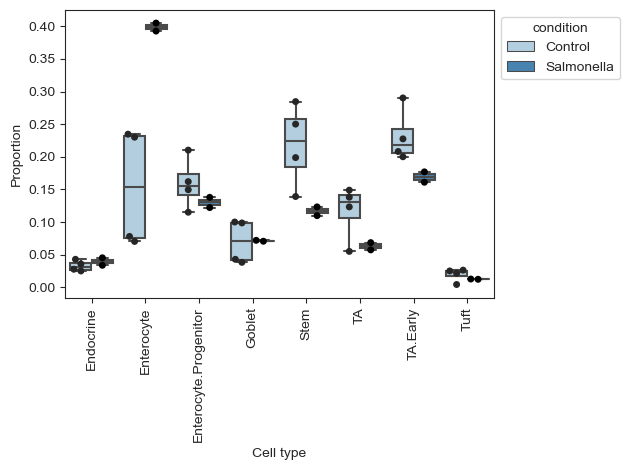

In [5]:
pt.pl.coda.boxplots(sccoda_data, modality_key="coda_salm", feature_name="condition", add_dots=True)
plt.show()

### Model setup and inference

We can now run parameter inference for the scCODA model to determine which cell types are credibly changing under Salmonella infection. To do this, we first need to specify all the necessary information through `sccoda_model.prepare`. We need to set:

- The `formula` parameter. It specifies how the covariates are used in the model.
It can process R-style formulas via the [patsy](https://patsy.readthedocs.io/en/latest/) package, e.g. `formula="Cov1 + Cov2 + Cov3"`.
Here, we simply use the "Condition" covariate of our dataset

- The `reference_cell_type` parameter is used to specify a cell type that is believed to be unchanged by the covariates in `formula`.
This is necessary, because compositional analysis must always be performed relative to a reference (See [Büttner, Ostner et al., 2021](https://www.nature.com/articles/s41467-021-27150-6) for a more thorough explanation).
If no knowledge about such a cell type exists prior to the analysis, taking a cell type that has a nearly constant relative abundance over all samples is often a good choice.
It is also possible to let scCODA find a suited reference cell type by using `reference_cell_type="automatic"`.
Here, we take Goblet cells as the reference.

In [6]:
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda_salm", formula="condition", reference_cell_type="Goblet")
sccoda_data["coda_salm"]


AnnData object with n_obs × n_vars = 6 × 8
    obs: 'condition'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

No-U-turn HMC sampling is then initiated by calling `sccoda_model.run_nuts()`.

In [7]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="coda_salm")
sccoda_data["coda_salm"]


sample: 100%|██████████| 11000/11000 [00:38<00:00, 282.42it/s, 127 steps of size 2.53e-02. acc. prob=0.83]


AnnData object with n_obs × n_vars = 6 × 8
    obs: 'condition'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_condition[T.Salmonella]'

### Result interpretation

Calling `sccoda_model.summary()`, we can see the most relevant information for further analysis:

In [8]:
sccoda_model.summary(sccoda_data, modality_key="coda_salm")

                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 6 samples, 8 cell types                                    │
│ Reference cell type                          │ Goblet                                                           │
│ Formula                                      │ condition                                                        │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ Endocrine                  1.120            34.585                                                              │
│ Enterocyte                 2.335           116.562                                                              │
│ Enterocyte.Progenitor      2.524           140.811                                                              │
│ Goblet                     1.753            65.132                                                              │
│ Stem                       2.708           169.257                                                              │
│ TA                         2.116            93.636                                                              │
│ TA.Early                   2.863           197.635                                                              │
│ Tuft                       0.432            17.382                                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                              Final Parameter  Expected Sample  log2-fold change                 │
│ Covariate             Cell Type                                                                                 │
│ conditionT.Salmonella Endocrine                  0.000            24.719            -0.484                      │
│                       Enterocyte                 1.350           321.499             1.464                      │
│                       Enterocyte.Progenitor      0.000           100.644            -0.484                      │
│                       Goblet                     0.000            46.553            -0.484                      │
│                       Stem                       0.000           120.976            -0.484                      │
│                       TA                         0.000            66.926            -0.484                      │
│                       TA.Early                   0.000           141.259            -0.484                      │
│                       Tuft                       0.000            12.424            -0.484                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

**Model properties**

First, the summary shows an overview over the model properties:
* Number of samples/cell types
* The reference cell type.
* The formula used

The model has two types of parameters that are relevant for analysis - intercepts and effects.
These can be interpreted like in a standard regression model:
Intercepts show how the cell types are distributed without any active covariates, effects show ho the covariates influence the cell types.

**Intercepts**

The first column of the intercept summary shows the parameters determined by the MCMC inference.

The "Expected sample" column gives some context to the numerical values.
If we had a new sample (with no active covariates) with a total number of cells equal to the mean sampling depth of the dataset,
then this distribution over the cell types would be most likely.

**Effects**

For the effect summary, the first column again shows the inferred parameters for all combinations of covariates and cell types.
Most important is the distinctions between zero and non-zero entries
A value of zero means that no statistically credible effect was detected.
For a value other than zero, a credible change was detected. A positive sign indicates an increase, a negative sign a decrease in abundance.

Since the numerical values of the "Final Parameter" column are not straightforward to interpret, the "Expected sample" and "log2-fold change" columns give us an idea on the magnitude of the change.
The expected sample is calculated for each covariate separately (covariate value = 1, all other covariates = 0), with the same method as for the intercepts.
The log-fold change is then calculated between this expected sample and the expected sample with no active covariates from the intercept section.
Since the data is compositional, cell types for which no credible change was detected, can still change in abundance as well, as soon as a credible effect is detected on another cell type due to the sum-to-one constraint.
If there are no credible effects for a covariate, its expected sample will be identical to the intercept sample, therefore the log2-fold change is 0.

**Interpretation**

In the salmonella case, we see only a credible increase of Enterocytes, while all other cell types are unaffected by the disease.
The log-fold change of Enterocytes between control and infected samples with the same total cell count lies at about 1.46.

We can also easily filter out all credible effects:

In [9]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda_salm")

Covariate                Cell Type            
condition[T.Salmonella]  Endocrine                False
                         Enterocyte                True
                         Enterocyte.Progenitor    False
                         Goblet                   False
                         Stem                     False
                         TA                       False
                         TA.Early                 False
                         Tuft                     False
Name: Final Parameter, dtype: bool

We can also visualize the results as a barplot:

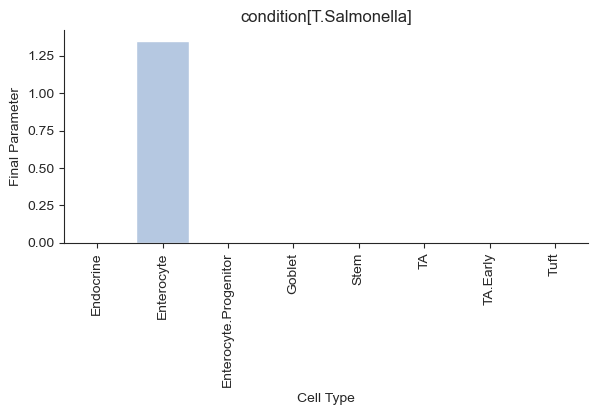

In [10]:
pt.pl.coda.effects_barplot(sccoda_data, modality_key="coda_salm", parameter="Final Parameter")

### Adjusting the False discovery rate

scCODA selects credible effects based on their inclusion probability.
The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR).
A smaller FDR value will produce more conservative results, but might miss some effects,
while a larger FDR value selects more effects at the cost of a larger number of false discoveries.

The desired FDR level can be easily set after inference via `sim_results.set_fdr()`. Per default, the value is 0.05,
but we recommend to increase it up to 0.2 if no effects are found at a more conservative level.

In our example, setting a desired FDR of 0.4 reveals small effects on Endocrine and Tuft cells. Keep in mind that we chose this value only for instructive purposes, since there are no credible effects beside Enterocytes at lower FDR levels. In practice, expecting 40% of all credible effects to be false-positives is usually not recommended.

In [11]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda_salm", est_fdr=0.4)
sccoda_model.summary(sccoda_data, modality_key="coda_salm")

                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 6 samples, 8 cell types                                    │
│ Reference cell type                          │ Goblet                                                           │
│ Formula                                      │ condition                                                        │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ Endocrine                  1.120            34.585                                                              │
│ Enterocyte                 2.335           116.562                                                              │
│ Enterocyte.Progenitor      2.524           140.811                                                              │
│ Goblet                     1.753            65.132                                                              │
│ Stem                       2.708           169.257                                                              │
│ TA                         2.116            93.636                                                              │
│ TA.Early                   2.863           197.635                                                              │
│ Tuft                       0.432            17.382                                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                              Final Parameter  Expected Sample  log2-fold change                 │
│ Covariate             Cell Type                                                                                 │
│ conditionT.Salmonella Endocrine                  0.280            32.384            -0.095                      │
│                       Enterocyte                 1.350           318.394             1.450                      │
│                       Enterocyte.Progenitor      0.000            99.672            -0.498                      │
│                       Goblet                     0.000            46.103            -0.498                      │
│                       Stem                       0.000           119.808            -0.498                      │
│                       TA                         0.000            66.280            -0.498                      │
│                       TA.Early                   0.000           139.894            -0.498                      │
│                       Tuft                       0.013            12.465            -0.480                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

### Saving results

The `MuData` object containing all relevant information can be saved e.g. as a `h5mu` file.
To access the saved data object, simply load it from disk and call the respective functions in an instance of a scCODA model

In [12]:
# saving
path = "test"
sccoda_data.write_h5mu(path)

# loading
sccoda_data_2 = mu.read_h5mu(path)

sccoda_model.summary(sccoda_data_2, modality_key="coda_salm")

                                          Compositional Analysis summary                                           
┌──────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────┐
│ Name                                         │ Value                                                            │
├──────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────┤
│ Data                                         │ Data: 6 samples, 8 cell types                                    │
│ Reference cell type                          │ Goblet                                                           │
│ Formula                                      │ condition                                                        │
└──────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                        Final Parameter  Expected Sample                                                         │
│ Cell Type                                                                                                       │
│ Endocrine                  1.120            34.585                                                              │
│ Enterocyte                 2.335           116.562                                                              │
│ Enterocyte.Progenitor      2.524           140.811                                                              │
│ Goblet                     1.753            65.132                                                              │
│ Stem                       2.708           169.257                                                              │
│ TA                         2.116            93.636                                                              │
│ TA.Early                   2.863           197.635                                                              │
│ Tuft                       0.432            17.382                                                              │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                              Final Parameter  Expected Sample  log2-fold change                 │
│ Covariate             Cell Type                                                                                 │
│ conditionT.Salmonella Endocrine                  0.280            32.384            -0.095                      │
│                       Enterocyte                 1.350           318.394             1.450                      │
│                       Enterocyte.Progenitor      0.000            99.672            -0.498                      │
│                       Goblet                     0.000            46.103            -0.498                      │
│                       Stem                       0.000           119.808            -0.498                      │
│                       TA                         0.000            66.280            -0.498                      │
│                       TA.Early                   0.000           139.894            -0.498                      │
│                       Tuft                       0.013            12.465            -0.480                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
import importlib
importlib.reload(pt)
test_model = pt.tl.Sccoda()

In [14]:
test_model.get_intercept_df(sccoda_data, modality_key="coda_salm")

,Final Parameter,HDI 3%,HDI 97%,SD,Expected Sample
Cell Type,,,,,
Endocrine,1.120,0.442,1.800,0.368,34.584989
Enterocyte,2.335,1.741,2.885,0.311,116.561584
Enterocyte.Progenitor,2.524,1.957,3.103,0.311,140.811168
Goblet,1.753,1.169,2.351,0.317,65.132246
Stem,2.708,2.126,3.264,0.305,169.257251
TA,2.116,1.515,2.721,0.326,93.636452
TA.Early,2.863,2.281,3.387,0.300,197.634577
Tuft,0.432,-0.299,1.154,0.394,17.381732


In [15]:
test_model.get_effect_df(sccoda_data, modality_key="coda_salm")


Final Parameter  HDI 3%  HDI 97%  \
Covariate             Cell Type                                                 
conditionT.Salmonella Endocrine                     0.279769  -0.481    1.132   
                      Enterocyte                    1.350402   0.839    1.843   
                      Enterocyte.Progenitor         0.000000  -0.396    0.595   
                      Goblet                        0.000000   0.000    0.000   
                      Stem                          0.000000  -0.775    0.241   
                      TA                            0.000000  -0.855    0.314   
                      TA.Early                      0.000000  -0.460    0.439   
                      Tuft                          0.013052  -1.019    0.895   

                                                SD  Inclusion probability  \
Covariate             Cell Type                                             
conditionT.Salmonella Endocrine              0.317                 0.4388   
                      Enterocyte             0.262                 1.0000   
                      Enterocyte.Progenitor  0.152                 0.3116   
                      Goblet                 0.000                 0.0000   
                      Stem                   0.215                 0.3928   
                      TA                     0.228                 0.3800   
                      TA.Early               0.119                 0.2690   
                      Tuft                   0.314                 0.4096   

                                             Expected Sample  log2-fold change  
Covariate             Cell Type                                                 
conditionT.Salmonella Endocrine                    32.383734         -0.094877  
                      Enterocyte                  318.393714          1.449719  
                      Enterocyte.Progenitor        99.672210         -0.498499  
                      Goblet                       46.103409         -0.498499  
                      Stem                        119.807573         -0.498499  
                      TA                           66.279914         -0.498499  
                      TA.Early                    139.894266         -0.498499  
                      Tuft                         12.465180         -0.479668

In [22]:
sccoda_data["coda_salm"].varm["intercept_df"]

,Final Parameter,HDI 3%,HDI 97%,SD,Expected Sample
Cell Type,,,,,
Endocrine,1.120,0.442,1.800,0.368,34.584989
Enterocyte,2.335,1.741,2.885,0.311,116.561584
Enterocyte.Progenitor,2.524,1.957,3.103,0.311,140.811168
Goblet,1.753,1.169,2.351,0.317,65.132246
Stem,2.708,2.126,3.264,0.305,169.257251
TA,2.116,1.515,2.721,0.326,93.636452
TA.Early,2.863,2.281,3.387,0.300,197.634577
Tuft,0.432,-0.299,1.154,0.394,17.381732
